In [1]:
from typing import List

import datetime

import numpy as np

import cirq
import openfermion as of
from openfermion.utils import count_qubits

from kcommute import get_si_sets, r_hat_measurement_count, k_qwc

import matplotlib.pyplot as plt

In [2]:
paulis = ("X", "Y", "Z")

In [3]:
def get_random_hamiltonian(
    nqubits: int,
    nterms: int,
    kappa: float,
    seed: int,
) -> of.QubitOperator:
    rng = np.random.RandomState(seed)

    hamiltonian = of.QubitOperator()
    for _ in range(nterms):
        weight = min(int(rng.exponential(scale=kappa)), nqubits)
        term = rng.choice(paulis, size=weight, replace=True)
        indices = [str(i) for i in rng.choice(range(nqubits), size=weight, replace=False)]
        hamiltonian += of.QubitOperator(
            " ".join(pauli + index for pauli, index in zip(term, indices)),
            coefficient=rng.normal(),
        )
    return hamiltonian

In [4]:
def max_index(array) -> float:
    if len(array) == 0:
        raise ValueError("Cannot find max index of an array with no elements.")
    imax = 0
    max = -np.inf
    for i in range(len(array)):
        if array[i] > max and not np.isclose(array[i], max):
            imax = i
            max = array[i]
    return imax

In [5]:
def find_kmax(hamiltonian: of.QubitOperator) -> int:
    n = count_qubits(hamiltonian)
    qs = cirq.LineQubit.range(n)
    kvals = np.arange(1, n + 1, 1)
    #rhats = [r_hat_measurement_count(get_si_sets(hamiltonian, comm_method="kqwc", k=k)) for k in kvals]
    rhats: List[float] = []
    for k in kvals:
        blocks = k_qwc.compute_blocks(qs, k)
        groups = get_si_sets(hamiltonian, blocks=blocks)
        rhats.append(r_hat_measurement_count(groups))
    return kvals[max_index(rhats)]

In [ ]:
now = datetime.datetime.now()
time_key = str(now).replace(" ", "_")

# Experiment parameters.
nmin: int = 10
nmax: int = 100
nstep: int = 2
ntrials: int = 50

nvals = np.arange(nmin, nmax + 1, nstep)
kappa_map = {"logn": np.log, "c5": lambda _: 5, "c2": lambda _: 2, "n": lambda n: n / 2}

for weight in kappa_map.keys():
    print("On weight:", weight)
    all_kvals = []
    for n in nvals:
        print("Status: n =", n)
        kvals = []
        for seed in np.arange(ntrials):
            print("Seed =", seed, "kappa =", kappa_map[weight](n))
            hamiltonian = get_random_hamiltonian(n, nterms=n, kappa=kappa_map[weight](n), seed=seed)
            kvals.append(find_kmax(hamiltonian))
        all_kvals.append(kvals)
        print(all_kvals)

        np.savetxt(f"all_kvals_random_hamiltonian_kmax_nmin_{nmin}_nmax_{nmax}_nstep_{nstep}_weight_{weight}_ntrials_{ntrials}_{time_key}.txt", all_kvals)

On weight: logn
Status: n = 10
Seed = 0 kappa = 2.3025850929940455
Seed = 1 kappa = 2.3025850929940455
Seed = 2 kappa = 2.3025850929940455
Seed = 3 kappa = 2.3025850929940455
Seed = 4 kappa = 2.3025850929940455
Seed = 5 kappa = 2.3025850929940455
Seed = 6 kappa = 2.3025850929940455
Seed = 7 kappa = 2.3025850929940455
Seed = 8 kappa = 2.3025850929940455
Seed = 9 kappa = 2.3025850929940455
Seed = 10 kappa = 2.3025850929940455
Seed = 11 kappa = 2.3025850929940455
Seed = 12 kappa = 2.3025850929940455
Seed = 13 kappa = 2.3025850929940455
Seed = 14 kappa = 2.3025850929940455
Seed = 15 kappa = 2.3025850929940455
Seed = 16 kappa = 2.3025850929940455
Seed = 17 kappa = 2.3025850929940455
Seed = 18 kappa = 2.3025850929940455
Seed = 19 kappa = 2.3025850929940455
Seed = 20 kappa = 2.3025850929940455
Seed = 21 kappa = 2.3025850929940455
Seed = 22 kappa = 2.3025850929940455
Seed = 23 kappa = 2.3025850929940455
Seed = 24 kappa = 2.3025850929940455
Seed = 25 kappa = 2.3025850929940455
Seed = 26 kappa =

In [39]:
fnames = [
    "all_kvals_random_hamiltonian_kmax_nmin_10_nmax_100_nstep_2_weight_c2_ntrials_50_2025-03-21_17:34:50.853252.txt",
    "all_kvals_random_hamiltonian_kmax_nmin_10_nmax_100_nstep_2_weight_logn_ntrials_50_2025-03-21_17:34:50.853252.txt",
    "all_kvals_random_hamiltonian_kmax_nmin_10_nmax_100_nstep_2_weight_n_ntrials_50_2025-03-21_17:34:50.853252.txt",
]
labels = [
    "$w = O(1)$",
    "$w = O(\log n)$",
    "$w = O(n)$",
]

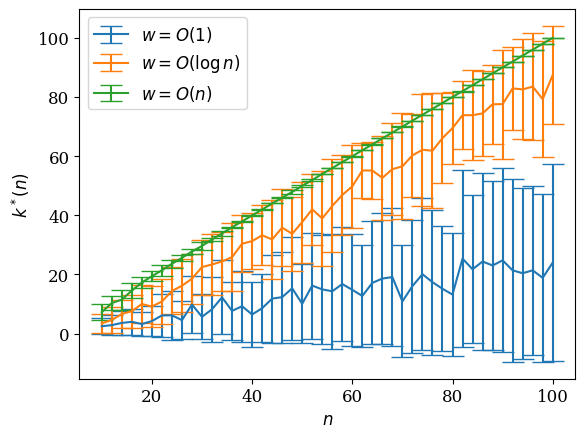

In [52]:
plt.rcParams.update({"font.family": "serif"})
plt.rc("legend", fontsize=12) # using a size in points
plt.rc("font", size=12)

for fname, label, in zip(fnames, labels):
    all_kvals = np.loadtxt(fname)
    plt.errorbar(nvals, np.average(all_kvals, axis=1), yerr=np.std(all_kvals, axis=1, ddof=1), capsize=8, label=label)
    plt.xlabel("$n$")
    plt.ylabel(r"$k^*(n)$")
plt.legend();
plt.savefig("kcutoff_random_hamiltonians_constant_and_log_and_linear_weight_v2.pdf")